In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import random

In [24]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'  
OUTPUT_DIR = './activation_maps'  
MODEL_PATH = '/kaggle/input/genage/gender_age_model.h5'  
IMG_SIZE = 128
LAYERS = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3'] 
MAX_FILTERS = 16 
OUTPUT_NAME = 'Age'  

In [25]:
#Choosing a single random image from UTK-Dataset
def load_data():
    files = [f for f in os.listdir(BASE_DIR) if f.endswith('.jpg')]
    if not files:
        print(f"No image files found in {BASE_DIR}")
        return pd.DataFrame()
        
    random_file = random.choice(files)
    try:
        temp = random_file.split('_')
        if len(temp) >= 2 and temp[0].isdigit() and temp[1].isdigit():
            age = int(temp[0])
            gender = int(temp[1])
            image_path = os.path.join(BASE_DIR, random_file)
        else:
            print(f"Skipping file {random_file}: Invalid format")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error processing file {random_file}: {e}")
        return pd.DataFrame()
        
    df = pd.DataFrame({'image': [image_path], 'age': [age], 'gender': [gender]})
    print(f"Selected image: {random_file}")
    print(f"DataFrame: \n{df}")
    return df

In [26]:
#Pre-process single image
def feature_extract(image_path):
    try:
        img = Image.open(image_path).convert("L") 
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        img_arr = np.array(img)
        img_arr = img_arr.reshape(1, IMG_SIZE, IMG_SIZE, 1)
        img_arr = img_arr / 255.0 
        return img_arr
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [27]:
#Age-weighted activation maps visualization
def visualize_age_weighted_activations(model, image, layer_names, output_name, output_dir, max_filters=MAX_FILTERS):
    os.makedirs(output_dir, exist_ok=True)
    
    #Validating layer names
    valid_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    invalid_layers = [name for name in layer_names if name not in valid_layers]
    if invalid_layers:
        print(f"Warning: Invalid layer names {invalid_layers}. Available Conv2D layers: {valid_layers}")
        layer_names = [name for name in layer_names if name in valid_layers]
        if not layer_names:
            print("No valid Conv2D layers found. Exiting visualization.")
            return
    
    #Expand image dimension to -> (1, 128, 128, 1)
    img_array = np.expand_dims(image, axis=0)
    
    for layer_name in layer_names:
        #Creating a model with a layer to output the pre-trained model result
        conv_layer = model.get_layer(layer_name)
        grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.get_layer(output_name).output])
        
        #Computing gradients
        with tf.GradientTape() as tape:
            conv_outputs, age_output = grad_model(img_array)
            age_pred = age_output[0] 
        
        grads = tape.gradient(age_pred, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Shape: (num_filters,)
        
        conv_outputs = conv_outputs[0] 
        num_filters = min(conv_outputs.shape[-1], max_filters)
        
        #Calculating the grid size
        cols = 4
        rows = (num_filters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes
        
        for i in range(num_filters):
            #Weighted activation and Normalizing
            weight = pooled_grads[i].numpy()
            act_map = conv_outputs[:, :, i].numpy() * weight
            act_map = np.maximum(act_map, 0)  # ReLU
            act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min() + 1e-8) 
            axes[i].imshow(act_map, cmap='jet')
            axes[i].set_title(f'Filter {i+1} (Weight: {weight:.4f})')
            axes[i].axis('off')
        
        for i in range(num_filters, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'{layer_name}_age_weighted_activations.png')
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.close()
        print(f'Saved age-weighted activation maps for {layer_name} to {output_path}')

Model loaded successfully from /kaggle/input/genage/gender_age_model.h5
Model input shape: (None, 128, 128, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 9216)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Gender (Dense)            │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age (Dense)               │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,107,460 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Selected image: 40_1_0_20170117091858010.jpg.chip.jpg
DataFrame: 
                                               image  age  gender
0  /kaggle/input/utkface-new/UTKFace/40_1_0_20170...   40       1


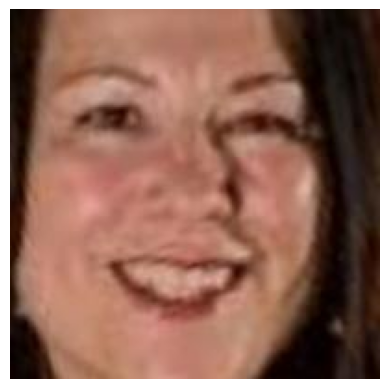

Sample image shape: (1, 128, 128, 1)
Saved age-weighted activation maps for conv2d to ./activation_maps/conv2d_age_weighted_activations.png
Saved age-weighted activation maps for conv2d_1 to ./activation_maps/conv2d_1_age_weighted_activations.png
Saved age-weighted activation maps for conv2d_2 to ./activation_maps/conv2d_2_age_weighted_activations.png
Saved age-weighted activation maps for conv2d_3 to ./activation_maps/conv2d_3_age_weighted_activations.png


In [35]:
#Loading pre-trained model
try:
    model = load_model(
        MODEL_PATH,
        custom_objects={'mae': tf.keras.metrics.MeanAbsoluteError})
    print("Model loaded successfully from", MODEL_PATH)
    print(f"Model input shape: {model.input_shape}")
    model.summary()
except Exception as e:
    print(f"Error loading model from {MODEL_PATH}: {e}")
    
#Loading single random image
df = load_data()

if not df.empty:
    #Displaying that random image
    try:
        img = Image.open(df['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Error opening image: {e}")
    x = feature_extract(df['image'][0])
    if x is not None:
        print(f"Sample image shape: {x.shape}")
        visualize_age_weighted_activations(model, x[0], LAYERS, OUTPUT_NAME, OUTPUT_DIR)